In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
## Reflection is the process of reading the database and building the metadata based on that information. 
## It's the opposite of creating a Table by hand and is very useful for working with existing databases

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()
# we have two classes: measurement and station

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# get table names
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

i = 1
n = 0
# printing table names
for table in table_names:
    print("Table " + str(i) + ": " + str(table))
    i = i + 1
# printing table types
    column_names = inspector.get_columns(table)
    for col in column_names:
        n += 1
        print("Column " + str(n) + ": " + str(col["name"]) + " (" + str(col["type"]) +")")

['measurement', 'station']
Table 1: measurement
Column 1: id (INTEGER)
Column 2: station (TEXT)
Column 3: date (TEXT)
Column 4: prcp (FLOAT)
Column 5: tobs (FLOAT)
Table 2: station
Column 6: id (INTEGER)
Column 7: station (TEXT)
Column 8: name (TEXT)
Column 9: latitude (FLOAT)
Column 10: longitude (FLOAT)
Column 11: elevation (FLOAT)


## Precipitation Analysis

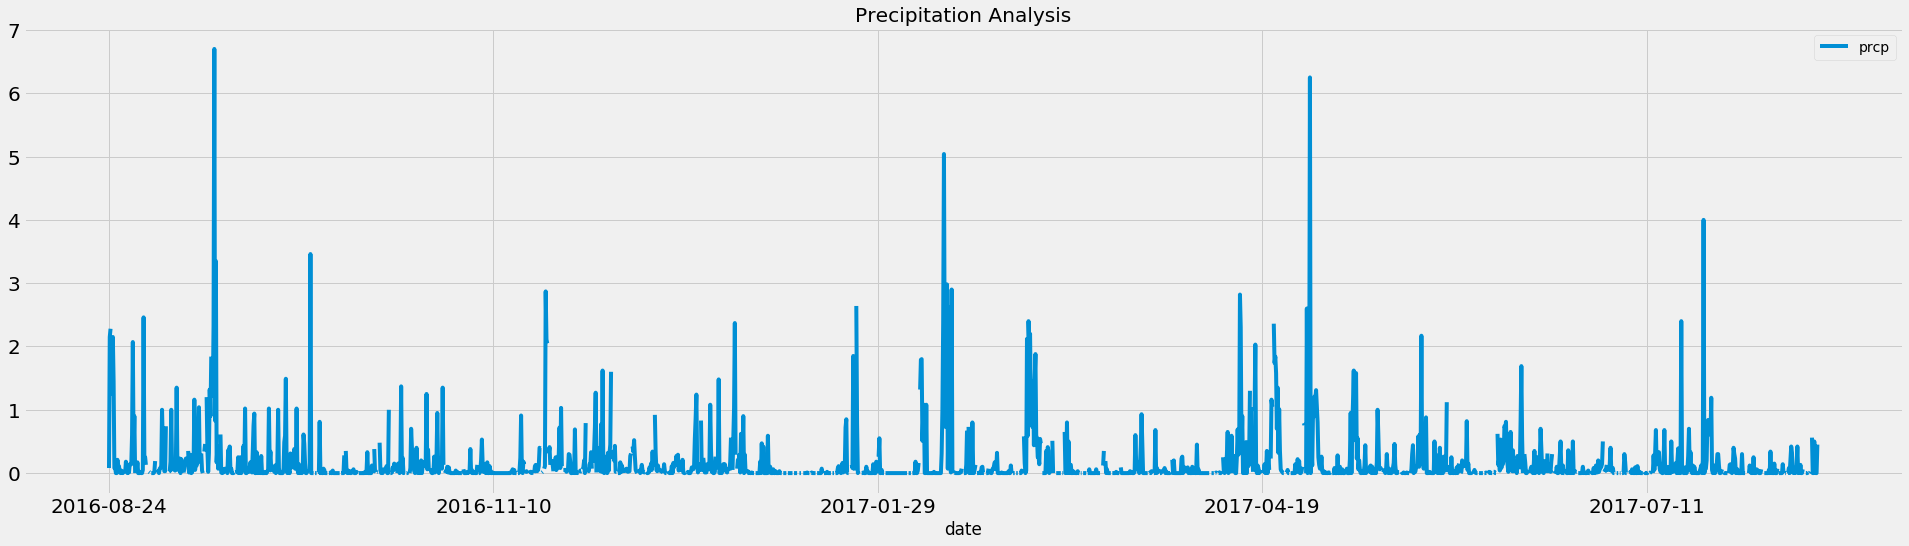

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# query object
latestquerydate = (session.query(measurement.date).order_by(measurement.date.desc()).first())

# extract string from query object
latestquerydate = list(np.ravel(latestquerydate))[0]

# convert to datetime object to work with it easier (year, month, day)
latestquerydate = dt.datetime.strptime(latestquerydate, '%Y-%m-%d')

# latestquerydate = dt.datetime.strftime(latestquerydate)
latestyear = int(dt.datetime.strftime(latestquerydate, "%Y"))
latestmonth = int(dt.datetime.strftime(latestquerydate, "%m"))
latestday = int(dt.datetime.strftime(latestquerydate, "%d"))

# calc one year before so now we have one year selected
lastyear = dt.date(latestyear, latestmonth, latestday)-dt.timedelta(days = 365)

# query for dates and prcp
precipquery = session.query(measurement.date, measurement.prcp).order_by(measurement.date)
precipquery = precipquery.filter(measurement.date > lastyear)

preciptable = pd.DataFrame(precipquery)
preciptable = pd.DataFrame(preciptable).sort_values('date')

# Save the query results as a Pandas DataFrame and set the index to the date column
preciptable = preciptable.set_index('date')

# plot the results
prcpplot = preciptable.plot(y="prcp",figsize=(30,8), fontsize=20, title = "Precipitation Analysis")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summarystats = round((preciptable.describe()), 3)
summarystats

,prcp
count,2015.000
mean,0.176
std,0.460
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


## Station Analysis

In [14]:
# Design a query to show how many stations are available in this dataset?
stationcount = session.query(station).count()
print(f"Stations: {stationcount}")

Stations: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stationcount = (session.query(measurement.station, func.count(measurement.station))
                        .group_by(measurement.station)
                        .order_by(func.count(measurement.station).desc())
                        .all())
# stationcount = (np.ravel(stationcount, order = 'K'))
# stationcount = pd.DataFrame(stationcount)
stationcount


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# query for the most active station
stationid = stationcount[0][0]
stationname = session.query(station.name).filter_by(station = stationid)
stationname = stationname[0][0]
print(f"Most active station: {stationname}")

Most active station: WAIHEE 837.5, HI US


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowesttemp = (session.query(measurement.tobs).filter(measurement.station == stationid)
                     .order_by(measurement.tobs.asc()).first())
lowesttemp = lowesttemp[0]
# -------
highesttemp = (session.query(measurement.tobs).filter(measurement.station == stationid)
                      .order_by(measurement.tobs.desc()).first())
highesttemp = highesttemp[0]
# -------
avgtemp = (session.query(func.avg(measurement.tobs)).filter(measurement.station == stationid))
avgtemp = round((avgtemp[0][0]), 1)

temp_data = {'Lowest Temp': [lowesttemp], 'Highest Temp': [highesttemp], 'Average Temp': [avgtemp]}
tempdata = pd.DataFrame(data = temp_data)

tempdata

,Lowest Temp,Highest Temp,Average Temp
0,54.0,85.0,71.7


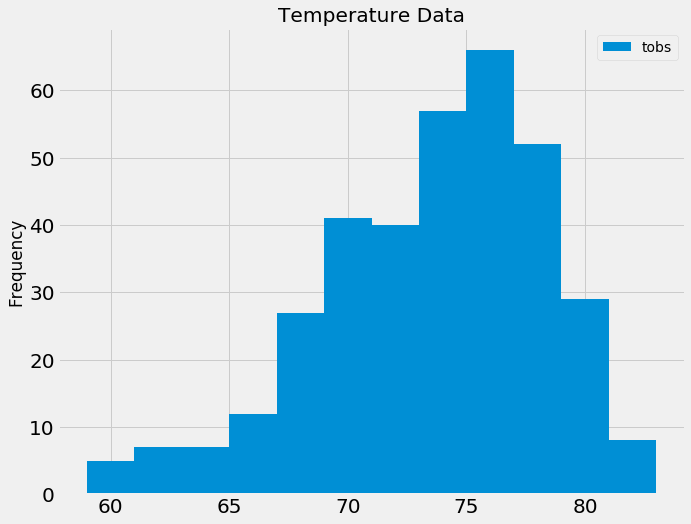

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram
highesttempobv = (session.query(measurement.station, measurement.tobs)
                        .filter(measurement.date > lastyear)
                   .filter(measurement.station == stationid)
                   .order_by(measurement.date)
                   .all())
tempTable = pd.DataFrame(highesttempobv)
tempTable = tempTable.set_index('station')

#histogram plot with pandas
tempTable.plot(kind='hist', bins=12, title = 'Temperature Data', figsize=(10,8), fontsize=20)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
